In [1]:
! pwd

/Users/eas/Documents/GitHub/fair_neighborhood/notebooks


In [2]:
import os
os.chdir('..')

import pandas as pd
import numpy as np
import torch
from scipy.sparse import lil_matrix

from prettytable import PrettyTable

from recpack.preprocessing.preprocessors import DataFramePreprocessor
from recpack.preprocessing.filters import Deduplicate, MinRating, MinItemsPerUser
from recpack.scenarios import WeakGeneralization, StrongGeneralization

from hyperopt import fmin, tpe, hp

# helpers & metrics
from src.helper_functions.data_formatting import *
from src.helper_functions.metrics_accuracy import *
from src.helper_functions.metrics_coverage import *
from src.helper_functions.metrics_exposure import *

# models
from src.recommenders.ease import myEASE
from src.recommenders.slim_bn import BNSLIM
from src.recommenders.fslr import FSLR
from src.recommenders.slim_bn_admm import BNSLIM_ADMM
from src.recommenders.mf_fair import FairMF
from src.recommenders.fda import FDA_bpr

import json
import re
import itertools
import time
# import pickle

import matplotlib.pyplot as plt

/Users/eas/Documents/GitHub/fair_neighborhood/venv/lib/python3.11/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [3]:
! pwd

/Users/eas/Documents/GitHub/fair_neighborhood


# Data Loading

In [4]:
# load ratings.dat from ml-1m folder
ratings = pd.read_csv("ml-1m/ratings.dat", sep="::", header=None, usecols=[0,1,2,3], names=["User_id","Item_id","Rating","Timestamp"], engine="python")

# load movies.dat from ml-1m folder
movies = pd.read_csv("ml-1m/movies.dat", sep="::", header=None, usecols=[0,1,2], names=["Item_id", "Title", "Genre"], encoding="latin-1", engine="python")
movies["Genre"] = movies["Genre"].apply(lambda x: x.split("|"))
movies_items = movies
movies = movies.explode("Genre")

# load users.dat from ml-1m folder
users = pd.read_csv("ml-1m/users.dat", sep="::", header=None, usecols=[0,1], names=["User_id", "Gender"], encoding="latin-1", engine="python")

# replace "M" with 0 and "F" with 1 in the "Gender" column
users["Gender"] = users["Gender"].replace({"M": 0, "F": 1})

# join ratings on users with User_id
ratings = pd.merge(ratings, users, on="User_id", how="left")

/var/folders/p_/s2y5jw396vjd9c8fql74n7600000gn/T/ipykernel_27911/2841187488.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  users["Gender"] = users["Gender"].replace({"M": 0, "F": 1})


In [6]:
ratings['datetime'] = pd.to_datetime(ratings['Timestamp'], unit='s')

# Data Preprocessing

In [8]:
ratings_pp = DataFramePreprocessor("Item_id", "User_id","Timestamp")

# define filters
deduplicate = Deduplicate("Item_id", "User_id", "Timestamp")
min_rating_filter = MinRating(4, "Rating")
min_items_per_user_filter = MinItemsPerUser(10, "Item_id", "User_id")

# add filters to pre-processor
ratings_pp.add_filter(deduplicate)
ratings_pp.add_filter(min_rating_filter)
ratings_pp.add_filter(min_items_per_user_filter)

# create interaction matrix object
im = ratings_pp.process(ratings)

# apply filters to ratings frame directly
ratings = min_items_per_user_filter.apply(min_rating_filter.apply(deduplicate.apply(ratings)))

movies = movies[movies["Item_id"].isin(ratings["Item_id"].unique())] # only keep items that are in the filtered ratings
raw_genre_dict = dict(movies.groupby("Genre")["Item_id"].apply(lambda x: list(set(x))))

# genre - inner iids dictionary
inner_genre_dict = {
    genre: get_inner_item_ids(ratings_pp, raw_iids)
    for genre, raw_iids in raw_genre_dict.items()
}

  0%|          | 0/574619 [00:00<?, ?it/s]

  0%|          | 0/574619 [00:00<?, ?it/s]

In [9]:
#### UPDATE
# Remove year from movie titles for better readability
YEAR_MOVIE_TITLES_PATTERN = r'\s*\(\d{4}\)'
original_movie_titles = movies.Title.unique()

In [10]:
#### UPDATE
# Create a mapping from original titles to updated titles without year
original_to_updated_titles = {title : re.sub(YEAR_MOVIE_TITLES_PATTERN,'',title) for title in original_movie_titles}

In [11]:
#### UPDATE
# Fix titles that have ", The" or ", A" at the end
for title in original_to_updated_titles:
    if "," in original_to_updated_titles[title]:
        parts = original_to_updated_titles[title].split(",")
        if len(parts) == 2:
            if parts[1] == ' The':
                original_to_updated_titles[title] = 'The ' + parts[0]
            elif parts[1] == ' A':
                original_to_updated_titles[title] = 'A ' + parts[0]
        
updated_to_original_titles = {original_to_updated_titles[original_title] : original_title for original_title in original_to_updated_titles}

In [12]:
#### UPDATE
pd.DataFrame.sparse.from_spmatrix(im.binary_values).head()

,0,1,2,3,4,5,6,7,8,9,...,3522,3523,3524,3525,3526,3527,3528,3529,3530,3531
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,1,1,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


# Data Statistics

In [13]:
# compute sparsity after filtering
sparsity = 1 - im.density

# calculate user interaction and item popularity ranges
user_interactions = im.binary_values.sum(axis=1)
item_popularities = im.binary_values.sum(axis=0)
print(f"User interaction ranges from {user_interactions.min()} to {user_interactions.max()}. Item popularity ranges from {item_popularities.min()} to {item_popularities.max()}.")

# get the raw ids of all users involved
raw_uids = get_raw_user_ids(ratings_pp, im.active_users)

# create uid - gender mapping df
gender_mapping_df = ratings[ratings["User_id"].isin(raw_uids)][["User_id", "Gender"]].drop_duplicates()

# get the raw/inner ids of all females involved
raw_uids_f = gender_mapping_df.loc[gender_mapping_df["Gender"] == 1, "User_id"].to_numpy()
inner_uids_f = get_inner_user_ids(ratings_pp, raw_uids_f)

# get the raw/inner ids of all males involved
raw_uids_m = gender_mapping_df.loc[gender_mapping_df["Gender"] == 0, "User_id"].to_numpy()
inner_uids_m = get_inner_user_ids(ratings_pp, raw_uids_m)

num_interactions_f, num_interactions_m = im.binary_values[inner_uids_f].sum(), im.binary_values[inner_uids_m].sum()

# table stats
statTable1 = PrettyTable(["data set","|U|","|I|","int(I)","sparsity"])
statTable1.add_row(["ML1M", str(im.num_active_users), str(im.num_active_items), str(im.num_interactions), str(round(sparsity*100,2))])
print(statTable1)

statTable2 = PrettyTable(["data set","attribute","|F|","int(F)","|M|","int(M)"])
statTable2.add_row(["ML1M", "gender", str(len(raw_uids_f)), str(num_interactions_f), str(len(raw_uids_m)), str(num_interactions_m)])
print(statTable2)

User interaction ranges from 10 to 1435. Item popularity ranges from 1 to 2832.
+----------+------+------+--------+----------+
| data set | |U|  | |I|  | int(I) | sparsity |
+----------+------+------+--------+----------+
|   ML1M   | 5950 | 3532 | 574619 |  97.27   |
+----------+------+------+--------+----------+
+----------+-----------+------+--------+------+--------+
| data set | attribute | |F|  | int(F) | |M|  | int(M) |
+----------+-----------+------+--------+------+--------+
|   ML1M   |   gender  | 1682 | 145372 | 4268 | 429247 |
+----------+-----------+------+--------+------+--------+


In [16]:
#### UPDATE
pd.merge(ratings, movies, on="Item_id", how="left")

,User_id,Item_id,Timestamp,Gender,datetime,Title,Genre
0,6040,858,956703932,0,2000-04-25 23:05:32,"Godfather, The (1972)",Action
1,6040,858,956703932,0,2000-04-25 23:05:32,"Godfather, The (1972)",Crime
2,6040,858,956703932,0,2000-04-25 23:05:32,"Godfather, The (1972)",Drama
3,6040,2384,956703954,0,2000-04-25 23:05:54,Babe: Pig in the City (1998),Children's
4,6040,2384,956703954,0,2000-04-25 23:05:54,Babe: Pig in the City (1998),Comedy
...,...,...,...,...,...,...,...
1205670,4958,1407,1046454443,0,2003-02-28 17:47:23,Scream (1996),Thriller
1205671,4958,3264,1046454548,0,2003-02-28 17:49:08,Buffy the Vampire Slayer (1992),Comedy
1205672,4958,3264,1046454548,0,2003-02-28 17:49:08,Buffy the Vampire Slayer (1992),Horror
1205673,4958,1924,1046454590,0,2003-02-28 17:49:50,Plan 9 from Outer Space (1958),Horror


<Figure size 1500x1000 with 0 Axes>

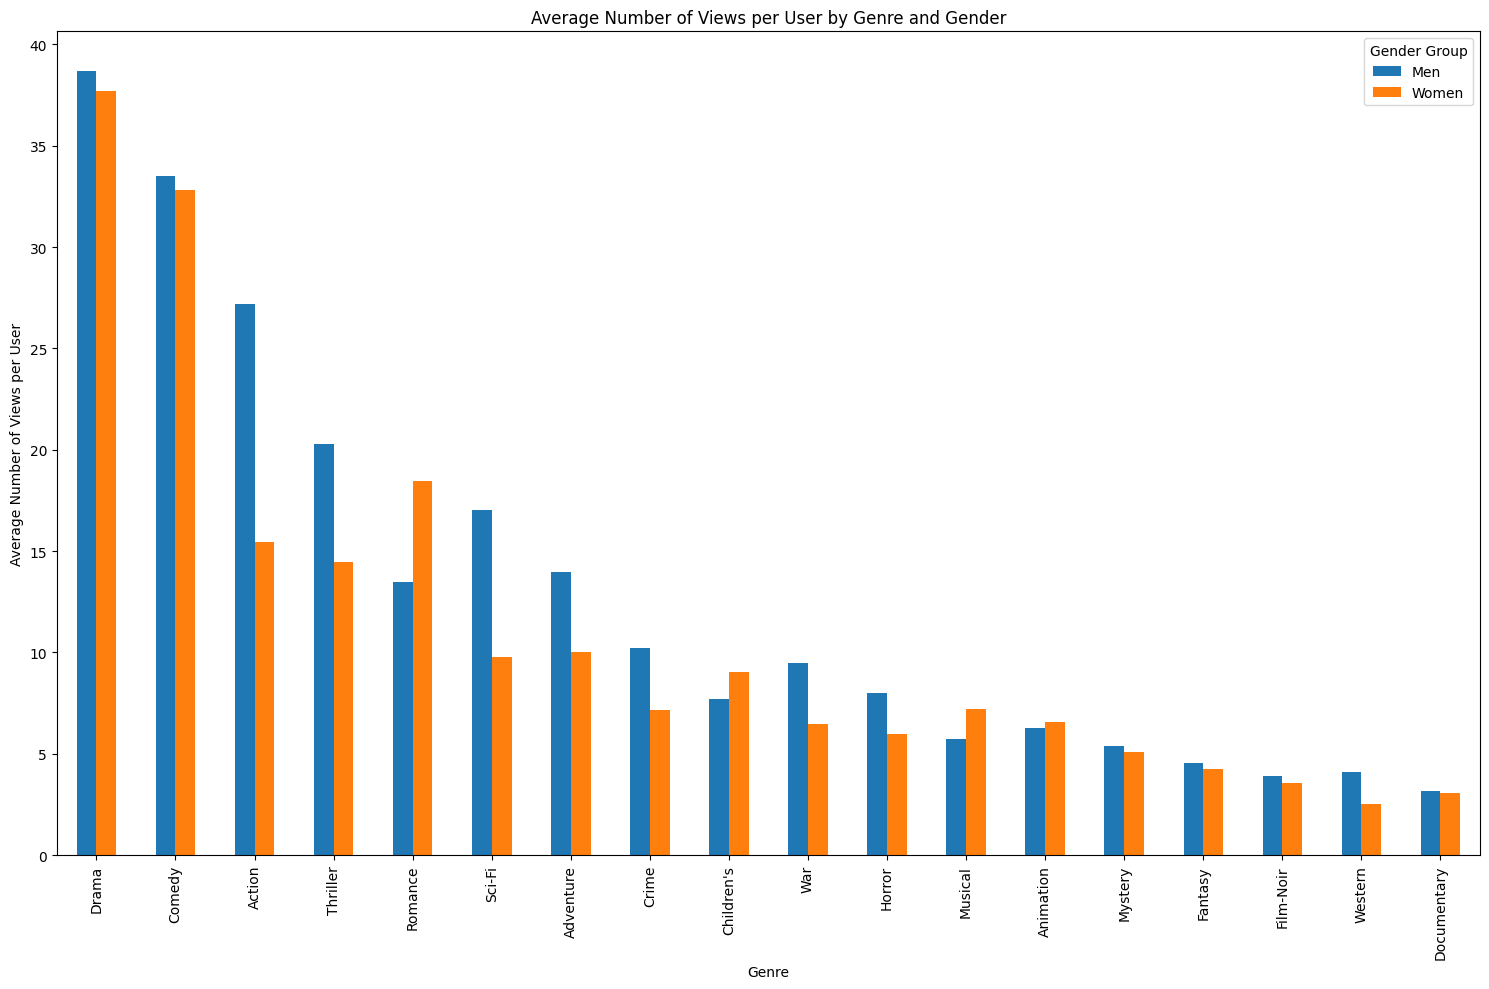

In [17]:
ratings_merged = pd.merge(ratings, movies, on="Item_id", how="left")

# Group by gender: 0 for Men and 1 for Women
ratings_merged["Gender_Group"] = (ratings_merged["Gender"] == 1).astype(int)

# Sum the number of interactions for each user within each genre and gender group
user_genre_gender_sum = ratings_merged.groupby(["User_id", "Genre", "Gender_Group"]).size().reset_index(name="Interactions")

# Calculate the average number of interactions per user for each genre and gender group
genre_gender_avg_interactions = user_genre_gender_sum.groupby(["Genre", "Gender_Group"])["Interactions"].mean().reset_index()

# Pivot the data for plotting
genre_gender_avg_interactions_pivot = genre_gender_avg_interactions.pivot(index="Genre", columns="Gender_Group", values="Interactions").fillna(0)

# Sort genres by average interactions
genre_gender_avg_interactions_pivot["Total"] = (genre_gender_avg_interactions_pivot[0] + genre_gender_avg_interactions_pivot[1]) / 2
genre_gender_avg_interactions_pivot_sorted = genre_gender_avg_interactions_pivot.sort_values(by="Total", ascending=False).drop(columns="Total")

# Plot
plt.figure(figsize=(15, 10))
genre_gender_avg_interactions_pivot_sorted.plot(kind="bar", figsize=(15,10))

plt.title("Average Number of Views per User by Genre and Gender")
plt.xlabel("Genre")
plt.ylabel("Average Number of Views per User")
plt.legend(["Men", "Women"], title="Gender Group")
plt.tight_layout()
plt.show()

# Experiments

In [18]:
# define K for Top-K
K = 20

# Define alpha, the parameter that balances the importance of NDCG and Equity in the objective function.
# Setting alpha = 0.5 gives equal weight to both metrics, aiming to balance relevance (NDCG) and fairness (Equity).
# Adjusting alpha allows for prioritizing one metric over the other.
# For instance, setting alpha closer to 1.0 would prioritize NDCG (accuracy), while setting it closer to 0.0 would prioritize Equity (fairness).
alpha = 0.5

# define seed; seeds tested (1452, 1994, 42, 7, 13800)
SEED = 1994

# define scenario
# Note: Due to the nature of the utilized algorithms (User-User neighborhood methods), 
# only scenarios that include the 'validation in' set in the 'validation training' set, 
# and the 'test in' set in the 'full training' set, are applicable.
scenario = WeakGeneralization(validation=True, seed=SEED)
scenario.split(im)

# define time threshold
SECONDS = 24*3600

# define number of evaluations
EVALUATIONS = 50

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [19]:
#### UPDATE
print("Users {} | Items: {}".format(scenario.full_training_data.binary_values.shape[0], scenario.full_training_data.binary_values.shape[1]))

Users 5950 | Items: 3532


## Hyperparameters optimizations

In [20]:
def accuracy_objective(model, fit_args={}):
    model.fit(scenario.validation_training_data.binary_values, **fit_args)

    # generate predictions and mask training interactions
    predictions = model.predict(scenario.validation_training_data.binary_values).toarray()
    predictions[scenario.validation_training_data.binary_values.nonzero()] = -np.inf

    ndcg, _ = tndcg_at_n(predictions, scenario.validation_data_out.binary_values, K)

    return 1-ndcg

def combined_objective(model, fit_args={}):
    model.fit(scenario.validation_training_data.binary_values, **fit_args)

    if "users_features" in fit_args: #fda
        predictions = model.model_.predict().toarray()
    else:
        predictions = model.predict(scenario.validation_training_data.binary_values).toarray()
    predictions[scenario.validation_training_data.binary_values.nonzero()] = -np.inf

    ndcg, _ = tndcg_at_n(predictions, scenario.validation_data_out.binary_values, K)
    equity, _, _ = c_equity_at_n(predictions[inner_uids_f, :], predictions[inner_uids_m, :], inner_genre_dict, K)

    return alpha * (1-ndcg) + (1 - alpha) * equity

In [21]:
# for fairmf
sst_field = torch.zeros((im.num_active_users, im.num_active_items), dtype=torch.bool)
sst_field[inner_uids_f, :] = True

# for fda
users_features = np.zeros(im.num_active_users); users_features[inner_uids_m] = 1

### Optimize EASE

In [ ]:
# optimize ease
optimisation_results_ease = fmin(
    fn=lambda param: accuracy_objective(myEASE(l2=param["l2"], method="user")),
    space={"l2": hp.loguniform("l2", np.log(1e0), np.log(1e4))},
    algo=tpe.suggest,
    timeout = SECONDS,
    max_evals = EVALUATIONS,
)

### Optimize BNSlim (spend a lot of time)

In [ ]:
# optimize bnslim
optimisation_results_bnslim = fmin(
    fn=lambda param: combined_objective(BNSLIM(knn=100, l1=param["l1"], l2=param["l2"], l3=param["l3"], method="user", seed=SEED), {"inner_ids_npr": inner_uids_m}),
    space={"l1": hp.loguniform("l1", np.log(1e-3), np.log(7)),
           "l2": hp.loguniform("l2", np.log(1e-3), np.log(7)),
           "l3": hp.loguniform("l3", np.log(1e1), np.log(1e4))
           }, 
    algo=tpe.suggest,
    timeout=SECONDS,
    max_evals=EVALUATIONS
)

### Optimize FSLR

In [ ]:
# optimize fslr
optimisation_results_fslr = fmin(
    fn=lambda param: combined_objective(FSLR(l1=param["l1"], l2=param["l2"], method="user"), {"inner_ids_pr": inner_uids_f, "inner_ids_npr": inner_uids_m}),
    space={"l1": hp.loguniform("l1", np.log(1e-3), np.log(1e1)),
           "l2": hp.loguniform("l2", np.log(1e0), np.log(1e4))},
    algo=tpe.suggest,
    timeout=SECONDS,
    max_evals=EVALUATIONS
)

### Optimize BNSlim ADMM (proposed)

In [ ]:
# optimize bnslim admm
optimisation_results_bnslim_admm = fmin(
    fn=lambda param: combined_objective(BNSLIM_ADMM(l1=param["l1"], l2=param["l2"], l3=param["l3"], method="user"), {"inner_ids_npr": inner_uids_m}),
    space={"l1": hp.loguniform("l1", np.log(1e-3), np.log(50)),
           "l2": hp.loguniform("l2", np.log(1e0), np.log(1e4)),
           "l3": hp.loguniform("l3", np.log(1e-3), np.log(1e3))},
    algo=tpe.suggest,
    timeout = SECONDS,
    max_evals = EVALUATIONS,
)

### Optimize FairMF (proposed)

In [ ]:
# optimize FairMF
factor_choices = [32, 64, 128]
optimisation_results_fairmf = fmin(
    fn=lambda param: combined_objective(FairMF(batch_size=im.num_active_users, learning_rate=param["learning_rate"], l2=param["l2"], num_factors=param["num_factors"], seed=SEED), {"sst_field": sst_field}),
    space={"learning_rate": hp.loguniform("learning_rate", np.log(1e-6), np.log(1e0)),
           "l2": hp.loguniform("l2", np.log(1e-6), np.log(1e-1)),
           "num_factors": hp.choice("num_factors", factor_choices)
           },
    algo=tpe.suggest,
    timeout=SECONDS,
    max_evals=EVALUATIONS
)

optimisation_results_fairmf["num_factors"] = factor_choices[optimisation_results_fairmf["num_factors"]]

### Optimize FDA (BPR)

In [ ]:
# optimize FDA
# define the parameter choices
num_ng_choices = [5, 7, 9, 10]
ratio_choices = [0.1, 0.3, 0.5, 0.7]
all_combinations = itertools.product(num_ng_choices, ratio_choices)

best_params = None
best_score = float("inf")

for num_ng, noise_ratio in all_combinations:
    score = combined_objective(
        FDA_bpr(num_ng=num_ng, noise_ratio=noise_ratio, seed=SEED), 
        {"users_features": users_features}
    )

    if score < best_score:
        best_score = score
        best_params = {"num_ng": num_ng, "noise_ratio": noise_ratio}

In [ ]:
opt_params = {}
opt_params.update({
    "ease": optimisation_results_ease,
    "bnslim": optimisation_results_bnslim,
    "fslr": optimisation_results_fslr,
    "bnslim_admm": optimisation_results_bnslim_admm,
    "fairmf": optimisation_results_fairmf,
    "fda": best_params
})

folder = f"ml-1m/{SEED}"; os.makedirs(folder, exist_ok=True)
with open(folder + "/opt_params.json", "w") as f: json.dump(opt_params, f, indent=4)

## Gpt request method (for reranking)

In [22]:
from openai import OpenAI
import os

def ask_to_gpt(messages, gpt_model='gpt-4.1-nano',max_tokens=1024,temperature=0,n_retry=2,verbose=False):

    client = OpenAI(
        api_key = os.getenv('OPENAI_API_KEY')
    )

    if verbose:
        print("================ OpenAI API call =================")
        print(" > Model: ", gpt_model)
        print(" > temperature: ", temperature)
        print(" > max_tokens: ", max_tokens)
        print("==================== Request =====================")
        #print(json.dumps(messages, indent=2))

    while n_retry:
        try:
            if verbose:
                print('Please wait...')
            response = client.chat.completions.create(
                  model=gpt_model,
                  messages=messages,
                  max_completion_tokens=max_tokens,
                  #modalities=['text'],
                  temperature=temperature,# [0-2]
                  top_p=1,                
                  frequency_penalty=0,    # [-2, 2]
                  presence_penalty=0,     # [-2,2]
                  n = 1,                  # [>1]
              )
            if verbose:
                print("==================== Answer ======================")
                #display(response.choices[0].message.content)
                print("==================== Stats =======================")
                print(dict(response).get('usage'))
                print("==================================================")

            chat_completion = {
                "prompt": messages,
                "completion": response,
            }
            return chat_completion
        except Exception as e:
            print(f"An exception occurred in the GPT request: {str(e)}")
            if n_retry > 0:
                print('Trying request GPT again in few seconds!\nWait...')
            else:
                raise f"The trying limit was reached.\nExiting... with the error: {str(e)}"
            
            n_retry -= 1
            time.sleep(5) # Wait 5 seconds
            print('Trying again!')
    raise "The trying limit was reached.\nExiting..."

## Translate data from original dataset

In [23]:
def get_user_history(df_pp,inner_user_id):
    raw_user_id = get_raw_user_ids(df_pp, [inner_user_id])[0]
    user_history_items_title = ratings_merged.loc[ratings_merged.User_id == raw_user_id,['Title','Timestamp']].sort_values(by='Timestamp')['Title'].unique()
    return [ original_to_updated_titles[uhit] for uhit in user_history_items_title ]

def get_raw_item_id(title : str):
    return ratings_merged.loc[ratings_merged.Title == title,'Item_id'].unique()[0]

## 2-step Reranking Method (Preferences + Recommendation)

In [24]:
def build_preferences_prompt(user_history_items):
  
  persona = 'You are a movie recommender specialist, tell me what are my preferences and explain them.'
  prompt = '''The movies I have watched (watched movies): {}.

What features are most important to me when selecting movies (Summarize my preferences briefly)?
Answer:'''.format( ', '.join(user_history_items) )
   
  return [{"role":"system", "content": persona}, {"role":"user","content": prompt}]

def build_recommendation_prompt(user_history_items,candidate_set, preferences_completion, n_items=10):
    
    persona = f'You are a movie recommender specialist, based on my preferences, recommend {n_items} movies to me watch next and explain the recommendations'

    prompt = f'''Candidate Set (candidate movies): {', '.join(candidate_set)}.

Recommend {n_items} movies from the Candidate Set based on my preferences and similarity with the movies I have watched.
Format: [position. recommended movie name :: recommendation reason] as follow:
1. Recommended item 1:: recommendation reason 1.
2. Recommended item 2:: recommendation reason 2.

Answer:'''

    prefs_prompt = build_preferences_prompt(user_history_items)

    recsys_prompt = [
        {"role": "system", "content": persona},
        {"role": "user", "content": prefs_prompt[1]['content']},
        {"role": "assistant", "content": preferences_completion },
        {"role": "user", "content": prompt}
    ]
    return recsys_prompt

def generate_prompts(model_name, K, result_list, reranking_top_K=10):
    test_cases = list()
    # For each user
    for inner_user_id, top_items in enumerate(result_list[model_name][f"top_{K}"]):
        user_history = get_user_history(ratings_pp,inner_user_id) 

        sorted_top_items = sorted(top_items, key=lambda item: item['position']) # Keep the same item positions from backbones
        user_candidate_set = [item['item_title'] for item in sorted_top_items]

        user_history_reranking = []
        for history_item in user_history: 
            if history_item not in user_candidate_set: # Avoid candidate set items in the user's history prompt input
                user_history_reranking.append(history_item)
       
        if len(user_history) != len(user_history_reranking): # Only reranking users with ground-truth in the candidate set
            user_preferences_prompt = build_preferences_prompt(user_history_reranking)
            user_recsys_prompt = build_recommendation_prompt(user_history_reranking,
                                                             user_candidate_set, 
                                                             "###PREF_COMPLETION###", # To be replaced after 1st completion
                                                             n_items=reranking_top_K)
            
            reranking_user_info = {
                'inner_user_id': inner_user_id,
                'backbone' : model_name,
                'candidates' : K,
                'reranking_k' : reranking_top_K,
                'preferences_prompt': user_preferences_prompt,
                'recsys_prompt': user_recsys_prompt
            }
            test_cases.append(reranking_user_info) ## Only add user as test case for reranking if above conditions are met
    return test_cases

def get_2step_user_recommendations(user,gpt_model='gpt-4.1-nano',max_tokens=1024,temperature=0):
    ## Step 1. Prompt Preferences
    response_1 = ask_to_gpt(user['preferences_prompt'],gpt_model,max_tokens,temperature)
    user['recsys_prompt'][2]['content'] = response_1['completion'].choices[0].message.content
    ## Step 2. Prompt Recommendations
    response_2 = ask_to_gpt(user['recsys_prompt'],gpt_model,max_tokens,temperature)

    user['preferences_completion'] = response_1['completion'].choices[0].message.content
    user['recsys_completion'] = response_2['completion'].choices[0].message.content
    user['gpt_info'] = {
        "model" : gpt_model,
        "max_tokens" : max_tokens,
        "temperature" : temperature
    }
    with open(f"ml-1m/{SEED}/users_completions/UserCompletion-{user['inner_user_id']}.json","w") as f: json.dump(user,f,indent=2)
    return user['preferences_completion'], user['recsys_completion']

## LLM output parsing

In [25]:
from typing import List, Tuple

def format_recommendation_response(recsys_response : str) -> List[str]: # maybe it is need from typing import List and use List[str] (first List letter in Uppercase)
    """
    Generate a list of recommendation based on the completion/response of
    GPT API with each fund name followed by an explanation about the recommender.

    Param:
    @recsys_response: The completion/response generated by OpenAI API to the recommender prompt.

    Return a list of recommended items with a little description about the recommendation. 
    The format of each item string is: [no. **name**:: description]. The ** are Markdown-based.
    """

    # Split response in items
    split_pattern = '\n\s*\n*'
    rec_responses = re.split(split_pattern, recsys_response)

    rec_items = []
    for response in rec_responses:
        if re.match(r"^[0-9]",response):
            response = re.sub('\*\*','',response)
            response = re.sub('\*\*','',response)
            response = re.sub('(^[0-9]+)\s*(–|-|\.)\s*','\\1. ',response)
            response = re.sub('(^[0-9]+\.)\s*(–|-)','\\1',response)
            response = re.sub('\s(–|-)',':',response)
            response = re.sub('(^[0-9]+)\s*\)','\\1.',response)
            response = re.sub('(^[0-9]+\.\s)','\\1**',response)
            response = re.sub('::','**::',response)
            rec_items.append(response)
            
    return rec_items


def split_recommendation_reason(recommendations : List[str]) -> List[Tuple[str,str]]:

    result = []
    for rec in recommendations:
        parts = rec.split('::')
        result.append( (parts[0].strip(),parts[1].strip()) )
    
    return result

def get_rec_title_list(recommendations):
    titles = split_recommendation_reason(format_recommendation_response(recommendations))
    return [title.split("**")[1] for title, reason in titles ]
    

def get_rec_pos_title(recommendations,pos):

    title = split_recommendation_reason(format_recommendation_response(recommendations))
    if len(title) < pos: # Número de recomendações menor do que a posição solicitada
        raise "Fewer recommended items than requested!"
    title = title[pos-1][0]
    title = title.split("**")[1]
    title = title.replace('"','')
    title = title.replace("'",'')
    
    return title.strip()


def get_rec_pos_explanation(recommendations,pos):

    title = split_recommendation_reason(format_recommendation_response(recommendations))
    if len(title) < pos: # Número de recomendações menor do que a posição solicitada
        raise "Fewer recommended items than requested!"
    title = title[pos-1][1]
    
    return title.strip()

In [26]:
#### UPDATE
def get_user_ranking(user_id,items_ids):
    raw_items_ids = get_raw_item_ids(ratings_pp,items_ids)      # RAW: from dataset
    #inner_items_ids = get_inner_item_ids(ratings_pp,items_ids) # INNER: used by recpack
    rec_items = []
    for i, item_id in enumerate(raw_items_ids):
        item_original_title = movies_items[movies_items.Item_id == item_id].Title.values[0]
        rec_item = {
            "item_id": int(item_id),
            "item_title": original_to_updated_titles[item_original_title],
            "position": i+1
        }
        rec_items.append(rec_item)

    return rec_items

def get_all_users_ranking(top_n_predictions):
    users = []
    for inner_user_id, item_list in enumerate(top_n_predictions):
        users.append(get_user_ranking(inner_user_id,item_list))
    return users

## Train, test and evaluate models

In [27]:
with open(f"ml-1m/{SEED}/opt_params.json", "r") as f: opt_params = json.load(f)

def initialize_models(opt_params):
    return {
        "ease": myEASE(l2=opt_params["ease"]["l2"], method="user"),
        "bnslim": BNSLIM(knn=100, l1=opt_params["bnslim"]["l1"], l2=opt_params["bnslim"]["l2"], l3=opt_params["bnslim"]["l3"], maxIter=50, method="user", seed=SEED),
        "fslr": FSLR(l1=opt_params["fslr"]["l1"], l2=opt_params["fslr"]["l2"], method="user"),
        "bnslim_admm": BNSLIM_ADMM(l1=opt_params["bnslim_admm"]["l1"], l2=opt_params["bnslim_admm"]["l2"], l3=opt_params["bnslim_admm"]["l3"], method="user"),
        "fairmf": FairMF(batch_size=im.num_active_users, l2=opt_params["fairmf"]["l2"], learning_rate=opt_params["fairmf"]["learning_rate"], num_factors=opt_params["fairmf"]["num_factors"], seed=SEED),
        "fda": FDA_bpr(
            noise_ratio=opt_params["fda"]["noise_ratio"], 
            num_ng=opt_params["fda"]["num_ng"],
            seed=SEED
        )
    }

# initialize models
models = initialize_models(opt_params)

# define the models, list sizes, and metrics
#list_sizes = [10, 20, 50, 100]
list_sizes = [10,20]
metrics = ["recall",'recall_reranking',"ndcg", "ndcg_reranking", ## UPDATE
           "c-equity","c-equity_reranking", "u-parity","u-parity_reranking"] ## UPDATE

# initialize a dictionary to store results with mean and standard deviation
results = {
    "iters_num": {model: 0 for model in ["bnslim", "fslr", "bnslim_admm", "fairmf"]},
    "fit_time": {model: 0 for model in models.keys()},
    "reranking_sample_users": {model: 0 for model in models.keys()}, ## UPDATE
    **{metric: {model: {size: {"mean": 0, "std": 0} for size in list_sizes} for model in models.keys()} for metric in metrics},
}

result_list = {}

In [28]:
### UPDATE
reranking_test_cases = dict()
reranking_list_size = 10   # Reranking to 10 items with LLM
reranking_users_sample = 20 # 20 usuários por método para amostrar

In [316]:
import random

for model_name, model in models.items():
    params = {}
    if model_name == "fslr":
        params = {"inner_ids_pr": inner_uids_f, "inner_ids_npr": inner_uids_m}
    elif model_name in ["bnslim", "bnslim_admm"]:
        params = {"inner_ids_npr": inner_uids_m}
    elif model_name == "fairmf":
        params = {"sst_field": sst_field}
    elif model_name == "fda":
        params = {"users_features": users_features}

    print(f"####### Model info: {model_name} - {model} ########")
    ## TRAINING
    start_time = time.time()
    model.fit(scenario.full_training_data.binary_values, **params)
    results["fit_time"][model_name] = time.time() - start_time

    if model_name in results["iters_num"]:
        if model_name == "fairmf":
            results["iters_num"][model_name] = model.epochs
        else:
            results["iters_num"][model_name] = model.iters

    ## TEST
    # generate predictions and mask training interactions
    if model_name == "fda":
        y_pred = model.model_.predict()
    else:
        y_pred = model.predict(scenario.full_training_data.binary_values)

    predictions = y_pred.toarray()
    predictions[scenario.full_training_data.binary_values.nonzero()] = -np.inf

    ## EVALUATE
    # compute evaluation metrics for different values of K
    result_list[model_name] = {}
    reranking_test_cases[model_name] = dict()
    for K in list_sizes:
        #### UPDATE ####
        ## Get candidate set for reranking from original backbones (for each model and top K)
        result_list[f"{model_name}"][f"top_{K}"] = get_all_users_ranking(get_topn_indices(predictions,K))

#############################
        if K > reranking_list_size: # Only reranks if backbone filtering has more items than reranking list size
            ## Reranking STARTs here
            reranking_test_cases[model_name][f'top_{K}'] = generate_prompts(model_name, K, 
                                                                        result_list,
                                                                        reranking_top_K=reranking_list_size)

            sample_users = random.sample(reranking_test_cases[model_name][f'top_{K}'], reranking_users_sample)
            
            hallucination = 0 # Count users with any wrong item title identification problem (find exactly the same original name in dataset)
            reranked_predictions = predictions.copy()
            for user in sample_users:
                #print(user)
                ## Process LLM reranking
                
                ###############
                ### LLM CALL --->>> Costs here
                user_prefs, user_recs = get_2step_user_recommendations(user)
                ###############
                
                ## Retrieve raw list IDs from LLM reranked item titles
                original_title_list = []
                item_title_problem = False # When LLMs generates a item title different than available ones in dataset/candidate set
                for title in get_rec_title_list(user_recs):
                    ### Title string response Post-processing (source of some hallucinations "exactly match" with catalog title string)
                    title = title.strip()
                    title = title.replace("’","'")
                    ### 
                    if title in updated_to_original_titles:
                        original_title_list.append(updated_to_original_titles[title])
                    else:
                        print(f"Original title `{title}` not recognized - User: {user['inner_user_id']} in the [{model_name},top_{K}_{reranking_list_size}]")
                        item_title_problem = True
                        break
    
                if not item_title_problem:
                    result_list_id = [get_raw_item_id(original_title) for original_title in original_title_list ]
                    ## Get inner item IDs
                    result_inner_ids = get_inner_item_ids(ratings_pp,result_list_id)
    
                    ## Evaluate result
                    print('Inner User ID ',user['inner_user_id'],'Reranked items (inner ids): ', result_inner_ids)
                    # Update predictions based on reranking result
                    user_max_pred = max(predictions[user['inner_user_id']])
                    for i,result_item_index in enumerate(result_inner_ids):
                        reranked_predictions[user['inner_user_id']][result_item_index] = user_max_pred+len(result_inner_ids)-i
                else:
                    hallucination += 1

            print(f">>> Users with hallucination in reranking: {hallucination} / {len(sample_users)}")

            results["reranking_sample_users"][model_name] = len(sample_users) - hallucination
            # new accuracy metrics
            results["ndcg_reranking"][model_name][reranking_list_size]["mean"], results["ndcg_reranking"][model_name][reranking_list_size]["std"] = tndcg_at_n(reranked_predictions, scenario.test_data_out.binary_values, reranking_list_size)
            results["recall_reranking"][model_name][reranking_list_size]["mean"], results["recall_reranking"][model_name][reranking_list_size]["std"] = recall_at_n(reranked_predictions, scenario.test_data_out.binary_values, reranking_list_size)

            # fairness metrics
            results["c-equity_reranking"][model_name][reranking_list_size]["mean"], results["c-equity"][model_name][reranking_list_size]["std"], _ = c_equity_at_n(predictions[inner_uids_f, :], predictions[inner_uids_m, :], inner_genre_dict, reranking_list_size)

            females = np.ones(im.num_active_users); females[inner_uids_m] = 0
            results["u-parity_reranking"][model_name][reranking_list_size]["mean"], results["u-parity"][model_name][reranking_list_size]["std"] = u_parity_at_n(predictions, females, inner_genre_dict, reranking_list_size)
            
#############################

        # accuracy metrics
        results["ndcg"][model_name][K]["mean"], results["ndcg"][model_name][K]["std"] = tndcg_at_n(predictions, scenario.test_data_out.binary_values, K)
        results["recall"][model_name][K]["mean"], results["recall"][model_name][K]["std"] = recall_at_n(predictions, scenario.test_data_out.binary_values, K)

        # fairness metrics
        results["c-equity"][model_name][K]["mean"], results["c-equity"][model_name][K]["std"], _ = c_equity_at_n(predictions[inner_uids_f, :], predictions[inner_uids_m, :], inner_genre_dict, K)

        females = np.ones(im.num_active_users); females[inner_uids_m] = 0
        results["u-parity"][model_name][K]["mean"], results["u-parity"][model_name][K]["std"] = u_parity_at_n(predictions, females, inner_genre_dict, K)

    #break # Apenas 1 modelo
    # # save model
    #pickle.dump(model, open(f"ml-1m/{SEED}/{model_name}.pkl", "wb"))

print("DONE")

####### Model info: ease - myEASE ########
2025-09-04 04:18:32,809 - base - recpack - INFO - Fitting myEASE complete - Took 5.67s
Inner User ID  3060 Reranked items (inner ids):  [ 20  61 236 260 267 269 271 294 379 457]
Inner User ID  2753 Reranked items (inner ids):  [  2  12  13  18 130 133 136 137 621 906]
Inner User ID  351 Reranked items (inner ids):  [ 12  20  23 129 221 261 337 461 464 467]
Inner User ID  3050 Reranked items (inner ids):  [ 13 115 193 260 315 330 333 569 583 967]
Inner User ID  5041 Reranked items (inner ids):  [   0   15  112  113  115  134  137  155  193 1410]
Original title `Like Water for Chocolate` not recognized - User: 111 in the [ease,top_20_10]
Original title `Star Wars: Episode V: The Empire Strikes Back` not recognized - User: 237 in the [ease,top_20_10]
Inner User ID  705 Reranked items (inner ids):  [  19   40  155  261  330  457  514  639 1401 1929]
Original title `Star Wars: Episode V: The Empire Strikes Back` not recognized - User: 3503 in the [

/Users/eas/Documents/fair_neighborhood/src/recommenders/slim_bn.py:129: RuntimeWarning: overflow encountered in scalar multiply
  X_ik = np.sum(X[i,:] - W[i,mask] @ X[mask,:]) + self.l3 * p[k] * np.sum(p[mask] * W[i,mask])
/Users/eas/Documents/fair_neighborhood/src/recommenders/slim_bn.py:129: RuntimeWarning: invalid value encountered in matmul
  X_ik = np.sum(X[i,:] - W[i,mask] @ X[mask,:]) + self.l3 * p[k] * np.sum(p[mask] * W[i,mask])


Original title `Star Wars: Episode IV: A New Hope` not recognized - User: 1715 in the [bnslim,top_20_10]
Inner User ID  4354 Reranked items (inner ids):  [ 12  19  61 155 171 337 457 536 903 952]
Inner User ID  2858 Reranked items (inner ids):  [ 11  12  37  61 141 152 193 497 564 636]
Original title `Seven Samurai (The Magnificent Seven)` not recognized - User: 3680 in the [bnslim,top_20_10]
Original title `Star Wars: Episode V: The Empire Strikes Back` not recognized - User: 3865 in the [bnslim,top_20_10]
Original title `Star Wars: Episode V: The Empire Strikes Back` not recognized - User: 5069 in the [bnslim,top_20_10]
Original title `Star Wars: Episode IV: A New Hope` not recognized - User: 1644 in the [bnslim,top_20_10]
Original title `Star Wars: Episode IV: A New Hope` not recognized - User: 2641 in the [bnslim,top_20_10]
Inner User ID  5272 Reranked items (inner ids):  [ 19  27 221 238 271 413 457 569 585 657]
Inner User ID  393 Reranked items (inner ids):  [ 15  19  27  70 136 

# Save results

In [317]:
# save results
with open(f"ml-1m/{SEED}/results.json", "w") as f: json.dump(results, f, indent=4)

In [318]:
# save list results
with open(f"ml-1m/{SEED}/result_lists.json","w") as f: json.dump(result_list,f,indent=2)

# LLM Reranking (after backbone)

## Load users candidate set lists

In [ ]:
with open(f"ml-1m/{SEED}/result_lists.json","r") as f: result_list = json.load(f)

## Reranking as post-processing (test reranking method)

In [ ]:
reranking_test_cases = dict()
list_sizes = [20] # Reranking from 20 items filtered by backbones
reranking_list_size = 10 # Reranking to 10 items with LLM

for model_name, model in models.items():
    if model_name not in result_list:
        print(f'Without results for the model: {model_name}')
        continue

    reranking_test_cases[model_name] = dict()
    for K in list_sizes:
        if f"top_{K}" not in result_list[model_name]:
            print(f'Without results for the model {model_name} @ {K}')
            continue

        ## Reranking STARTs here
        reranking_test_cases[model_name][f'top_{K}'] = generate_prompts(model_name, K, 
                                                                        result_list,
                                                                        reranking_top_K=reranking_list_size)

        hallucination = 0 # Count users with any wrong item title identification problem (find exactly the same original name in dataset)
        for user in reranking_test_cases[model_name][f'top_{K}']:
            print(user)
            ## Process LLM reranking
            user_prefs, user_recs = get_2step_user_recommendations(user)
            
            ## Retrieve raw list IDs from LLM reranked item titles

            original_title_list = []
            item_title_problem = False
            for title in get_rec_title_list(user_recs):
                try:
                    original_title_list.append(updated_to_original_titles[title])
                except:
                    print(f"Original title `{title}` not recognized - User: {user}")
                    item_title_problem = True
                    break

            if not item_title_problem:
                result_list_id = [get_raw_item_id(original_title) for original_title in original_title_list ]
                ## Get inner item IDs
                result_inner_ids = get_inner_item_ids(ratings_pp,result_list_id)

                ## Evaluate result
                
            else:
                hallucination += 1
            
            #result_list_original_titles = [ updated_to_original_titles[title] for title in get_rec_title_list(user_recsys) ] # Not safe            
            #result_list_id = [get_raw_item_id(original_title) for original_title in result_list_original_titles ]
            ## Get inner item IDs
            #result_inner_ids = get_inner_item_ids(ratings_pp,result_list_id)

            break # Apenas 1 usuário

In [ ]:
result_list_original_titles = [ updated_to_original_titles[title] for title in get_rec_title_list(user_recsys) ]
result_list_id = [get_raw_item_id(original_title) for original_title in result_list_original_titles ]

# Get recpack inner item IDs
result_inner_ids = get_inner_item_ids(ratings_pp,result_list_id)

In [ ]:
import random

sample_users = random.sample(reranking_test_cases['ease']['top_20'], 1)

In [ ]:
for user in sample_users:
    # Get reranking list from LLM (2-step method)
    prefs, recs = get_2step_user_recommendations(user) # Default: Uses gpt-4-nano, max_tokens=1024, temperature=0
    #prefs5, recs5 = get_2step_user_recommendations(user,gpt_model='gpt-5-nano',max_tokens=8192,temperature=1)
    
    # Retrieve raw list IDs from LLM reranked item titles
    result_list_original_titles = [ updated_to_original_titles[title] for title in get_rec_title_list(recs) ]
    result_list_id = [get_raw_item_id(original_title) for original_title in result_list_original_titles ]

    # Get recpack inner item IDs
    result_inner_ids = get_inner_item_ids(ratings_pp,result_list_id)